In [1]:
import os

import pandas as pd
import math
import numpy as np 
import pandas as pd 
from scipy import stats
from sklearn import preprocessing
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

D:\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:

# Read feature csv files and concate as single dataframe

path_f = r'C:\Users\limju\Features' # use your path
all_feature_files = glob.glob(path_f + "/*.csv")

li = []

for filename in all_feature_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

In [3]:
#data = pd.read_csv("../Features/combined_csv.csv")
# Read label csv file
label = pd.read_csv('C:/Users/limju/Labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000 (1).csv', index_col=None, header=0)

In [4]:
print(label["bookingID"])

0         111669149733
1         335007449205
2         171798691856
3        1520418422900
4         798863917116
             ...      
20013     429496729754
20014     154618822713
20015     979252543488
20016    1657857376309
20017     558345748643
Name: bookingID, Length: 20018, dtype: int64


In [5]:
print(data)

              bookingID  Accuracy     Bearing  acceleration_x  acceleration_y  \
0         1202590843006     3.000  353.000000        1.228867        8.900100   
1          274877907034     9.293   17.000000        0.032775        8.659933   
2          884763263056     3.000  189.000000        1.139675        9.545974   
3         1073741824054     3.900  126.000000        3.871543       10.386364   
4         1056561954943     3.900   50.000000       -0.112882       10.550960   
...                 ...       ...         ...             ...             ...   
16135556   592705486872     3.000   59.000000        0.189148        9.670476   
16135557  1357209665551     7.000  290.154938       -1.576559       -8.460007   
16135558  1520418422900     3.900  253.000000       -0.143478       10.014740   
16135559  1700807049283     6.000    0.000000       -1.774103        9.313444   
16135560  1520418422978     3.000    0.000000        1.533486        9.551667   

          acceleration_z   

In [6]:
#Dropping labels that contains both 0 and 1
label = label.drop_duplicates(subset=['bookingID'], keep=False)
print(len(label))

19982


In [7]:
data = data.sort_values(by=['bookingID', 'second'], ascending=[True, True])
label = label.sort_values(by='bookingID', ascending=True)

In [8]:
df = pd.merge(left=data, right=label, how='inner', left_on='bookingID', right_on='bookingID')

In [9]:
df.bookingID.nunique()

19982

In [10]:
#df.to_csv("filtered_data_csv.csv", index=False, encoding="utf-8-sig")

In [11]:
#as the data seconds were not sorted we sort it by booking id first then by seconds
df.sort_values(['bookingID', 'second'], ascending=[True, True])

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16116699,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1
16116700,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1
16116701,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1
16116702,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1


In [12]:
#remove any rows with speed value of less than 0 as speed should not be going to negative
indexNames = df[ df['Speed'] < 0 ].index
df.drop(indexNames , inplace=True)

#remove any high accuracy value data as that would mean the data is inaccurate
indexNames = df[ df['Accuracy'] > 10 ].index
df.drop(indexNames , inplace=True)

In [13]:
df.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07,1.405310e+07
mean,8.177361e+11,5.201529e+00,1.692405e+02,7.644929e-02,5.314411e+00,1.069150e+00,-1.480772e-03,2.250958e-04,-3.492137e-04,6.054726e+02,9.239047e+00,3.002504e-01
std,4.949966e+11,2.222525e+00,1.072663e+02,1.385639e+00,7.658026e+00,3.094344e+00,1.341315e-01,3.482915e-01,1.353323e-01,4.620092e+02,8.131610e+00,4.583668e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-4.980000e-01,6.803399e+00,-7.374367e-01,-2.626232e-02,-2.916947e-02,-1.849365e-02,2.460000e+02,1.166782e+00,0.000000e+00
50%,8.074539e+11,4.000000e+00,1.690000e+02,6.943397e-02,9.202484e+00,9.050751e-01,-4.850270e-04,2.463421e-04,-6.981317e-05,5.270000e+02,7.956542e+00,0.000000e+00
75%,1.245541e+12,6.000000e+00,2.630000e+02,6.386566e-01,9.740103e+00,2.839523e+00,2.321288e-02,3.074898e-02,1.776396e-02,8.660000e+02,1.579001e+01,1.000000e+00
max,1.709397e+12,1.000000e+01,3.599995e+02,4.770832e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,4.280735e+01,1.000000e+00


In [14]:
df['Bearing'] = (df['Bearing'] - df['Bearing'].shift())
df['Bearing'] = df['Bearing'].fillna(value=0)

conv_bearings = [1 if values > 45 else 2 if values < -45 else 0 for values in df.Bearing]
df['Bearing'] = conv_bearings

left_turn = [1 if values == 2 else 0 for values in df.Bearing]
df['left_turn'] = left_turn

right_turn = [1 if values == 1 else 0 for values in df.Bearing]
df['right_turn'] = right_turn

In [15]:
#interaction between gyro and acceleration creating the vector theorem
#https://mathinsight.org/fundamental_theorems_vector_calculus_summary#:~:text=The%20four%20fundamental%20theorems%20of,the%20fundamental%20theorem%20of%20calculus.&text=Similarly%2C%20the%20fundamental%20theorems%20of,the%20boundary%20of%20that%20object.
df['acc_gyro_x']=df['acceleration_x']*df['gyro_x']
df['acc_gyro_y']=df['acceleration_y']*df['gyro_y']
df['acc_gyro_z']=df['acceleration_z']*df['gyro_z']
df['acc_gyro_xy']=np.sqrt(df['acc_gyro_x']**2+df['acc_gyro_y']**2)
df['acc_gyro_xz']=np.sqrt(df['acc_gyro_x']**2+df['acc_gyro_z']**2)
df['acc_gyro_yz']=np.sqrt(df['acc_gyro_z']**2+df['acc_gyro_y']**2)
df['acc_gyro_xyz']=np.sqrt(df['acc_gyro_x']**2+df['acc_gyro_y']**2+df['acc_gyro_z']**2)

In [16]:
#this is for aggresive turning having a high value of accel xy
df['acceleration_xy'] = df['acceleration_x']*df['acceleration_y']
#https://physics.stackexchange.com/questions/41653/how-do-i-get-the-total-acceleration-from-3-axes
#this site explains the understanding of why i did SQRT(x**2 + y**2 + z**2) in theory it gives 
#the net acceleration from all 3 points
#essentially calculating the momentum of vehicle
df['net_acceleration'] = np.sqrt((df['acceleration_x'] ** 2) + (df['acceleration_y'] ** 2) + (df['acceleration_z'] ** 2))

In [17]:
#Dimensionality reduction as phone orientation may be in different mode
#landscape/horizontal/flat
# Principal Components Analysis of Gyroscope Data
from sklearn.decomposition import PCA

pca_gyro = PCA(n_components=1).fit(df.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])
pca_gyro.explained_variance_ratio_

# transform triaxial gyro readings into its first principal components
# need change gyro readings into 
df['gyro'] = pca_gyro.transform(df.loc[:, ('gyro_x', 'gyro_y', 'gyro_z')])
df.drop(['gyro_x', 'gyro_y','gyro_z'], axis=1, inplace=True)

In [18]:
print(pca_gyro.components_)

[[0.01803475 0.99745455 0.0689867 ]]


In [19]:
multi = ['min','max', 'mean']
speedagg = ['max', 'mean', 'sum']
features_data = df.groupby('bookingID', as_index=False).agg({'left_turn' : 'sum' , 'right_turn' : 'sum','gyro': multi,'Speed' : speedagg, 'second':'max', 'acc_gyro_x': 'mean', 'acc_gyro_y': 'mean', 'acc_gyro_z': 'mean', 'acc_gyro_xy': 'mean', 'acc_gyro_xz': 'mean', 'acc_gyro_yz': 'mean' ,'acc_gyro_xyz': 'mean', 'acceleration_xy': multi,'net_acceleration': multi})
features_data.columns = features_data.columns.map('_'.join).str.strip('_')

features_data.head()

,bookingID,left_turn_sum,right_turn_sum,gyro_min,gyro_max,gyro_mean,Speed_max,Speed_mean,Speed_sum,second_max,...,acc_gyro_xy_mean,acc_gyro_xz_mean,acc_gyro_yz_mean,acc_gyro_xyz_mean,acceleration_xy_min,acceleration_xy_max,acceleration_xy_mean,net_acceleration_min,net_acceleration_max,net_acceleration_mean
0,0,4,5,-0.616873,0.417842,-0.005533,22.946083,11.429956,7612.350600,1589.0,...,0.633799,0.111464,0.648086,0.653731,-50.429753,44.473046,6.709258,6.457339,12.988328,9.893719
1,1,1,1,-0.660219,0.465602,-0.006778,21.882141,8.019369,6720.231233,1034.0,...,0.493978,0.056372,0.499971,0.500764,-50.123440,32.580673,-5.078168,6.970526,12.790147,9.865608
2,2,3,5,-0.462288,0.433975,-0.012706,9.360483,3.157213,615.656528,825.0,...,0.718235,0.038764,0.716790,0.721304,-33.144576,18.574741,2.960596,8.234988,13.403410,9.929590
3,4,3,3,-0.511868,0.654244,0.022561,19.780001,6.150996,6729.190006,1094.0,...,0.743528,0.125491,0.767880,0.769108,-22.237658,25.296284,3.378803,7.703982,21.053265,9.813434
4,6,5,8,-0.622211,0.538916,0.000346,16.394695,4.626175,5033.278186,1094.0,...,0.549958,0.100014,0.560699,0.565965,-46.244616,46.963084,4.598531,7.218154,14.498268,9.916871


In [20]:

features_data = features_data.rename(columns={'Speed_sum': 'Distance', 'left_turn_sum': 'left_turns', 'right_turn_sum': 'right_turns'})


In [21]:
features_data = pd.merge(features_data, label, on='bookingID', left_index=True, right_index=False, sort=False)

In [22]:
num_class_one = features_data.label.value_counts()[1] 
total_label_count = len(features_data.label)

# percentage of class 1 
print("Percentage of class 1 label: {:.2f}%".format((num_class_one / total_label_count) * 100))

Percentage of class 1 label: 24.91%


Only 24.91% of the training data is labeled as dangerous, thus a standard prediction of all safe would achieve a accuracy of 75%, we have to guage using AUC_score for better guaging against TPR/FPR

In [23]:
features_data.describe()

,bookingID,left_turns,right_turns,gyro_min,gyro_max,gyro_mean,Speed_max,Speed_mean,Distance,second_max,...,acc_gyro_xz_mean,acc_gyro_yz_mean,acc_gyro_xyz_mean,acceleration_xy_min,acceleration_xy_max,acceleration_xy_mean,net_acceleration_min,net_acceleration_max,net_acceleration_mean,label
count,1.982600e+04,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,...,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000
mean,8.164420e+11,6.136134,6.314688,-0.987750,0.939425,-0.000084,20.674966,8.574816,6548.835565,907.449763,...,0.187324,0.789455,0.810340,-39.540934,38.006168,0.875630,6.781157,14.095500,9.882695,0.249067
std,4.944551e+11,7.155381,7.128111,2.330859,2.390236,0.166069,5.360266,4.507628,5675.651763,479.809096,...,0.526920,1.715519,1.735378,45.940977,45.854235,6.997739,1.446234,4.351082,1.003915,0.432484
min,0.000000e+00,0.000000,0.000000,-75.408637,-1.308094,-18.297043,0.000000,0.000000,0.000000,5.000000,...,0.001122,0.007552,0.014125,-2571.001003,-29.786890,-335.673008,0.005074,1.039078,0.973356,0.000000
25%,3.865471e+11,2.000000,2.000000,-0.757278,0.409476,-0.006925,17.049999,5.250491,2256.101092,554.000000,...,0.055689,0.431833,0.439586,-44.867589,25.348596,-2.065928,6.138156,12.386395,9.787041,0.000000
50%,7.988639e+11,4.000000,4.000000,-0.556520,0.508979,-0.000486,20.856855,7.624879,4756.092203,839.000000,...,0.095201,0.599543,0.610847,-33.880498,32.953022,0.791996,6.955078,13.317477,9.863133,0.000000
75%,1.245541e+12,8.000000,8.000000,-0.431270,0.641137,0.005707,24.747053,11.215226,9362.773793,1213.000000,...,0.160477,0.804929,0.818709,-25.194010,42.408605,3.721229,7.626366,14.593850,9.940800,0.000000
max,1.709397e+12,254.000000,251.000000,0.158606,80.688387,8.400740,42.807346,29.544777,46029.643582,8235.000000,...,32.378680,149.413157,149.413466,32.460598,3138.486053,290.744215,34.317899,115.152244,39.802653,1.000000


In [24]:
#features_data.where(features_data.left_turns == 280)

features_data[(features_data['net_acceleration_max'] > 100)]

#drop any rows that turns more than 100 times in a trip, not realistic
#viewing the data only 3 bookings

#timeframe was short too so every 30 seconds in the trip they turn left and right
features_data = features_data.drop(features_data[features_data.left_turns > 100].index)

#drop any data that second is more than 5000, is not realistic for the distance travelled
features_data = features_data.drop(features_data[features_data.second_max > 5000].index)

#drop any data that speed is more than 33, equals to 120km/h sg law on expressway is 90km/h while on normal roads is 70
features_data = features_data.drop(features_data[features_data.Speed_max > 33].index)

#dropped any data that duration was 0
features_data = features_data.drop(features_data[features_data.second_max == 0].index)

#drop any data that distance travelled was 0 metres
features_data = features_data.drop(features_data[features_data.Distance == 0].index)

#drop the row that had 3000 seconds as duration however trip distance was 5 metres
features_data = features_data.drop(features_data[(features_data.second_max > 3000) & (features_data.Distance < 10)].index)

In [25]:
features_data[(features_data['left_turns'] > 100)]

,bookingID,left_turns,right_turns,gyro_min,gyro_max,gyro_mean,Speed_max,Speed_mean,Distance,second_max,...,acc_gyro_xz_mean,acc_gyro_yz_mean,acc_gyro_xyz_mean,acceleration_xy_min,acceleration_xy_max,acceleration_xy_mean,net_acceleration_min,net_acceleration_max,net_acceleration_mean,label


In [26]:
features_data[['second_max', 'label']].groupby(['label'], as_index=False).head()

,second_max,label
15035,1589.0,0
13312,1034.0,1
996,825.0,1
2328,1094.0,1
5192,1094.0,0
19504,959.0,0
9947,462.0,0
11921,374.0,0
19990,1034.0,1
12161,1664.0,1


Wall time: 749 ms


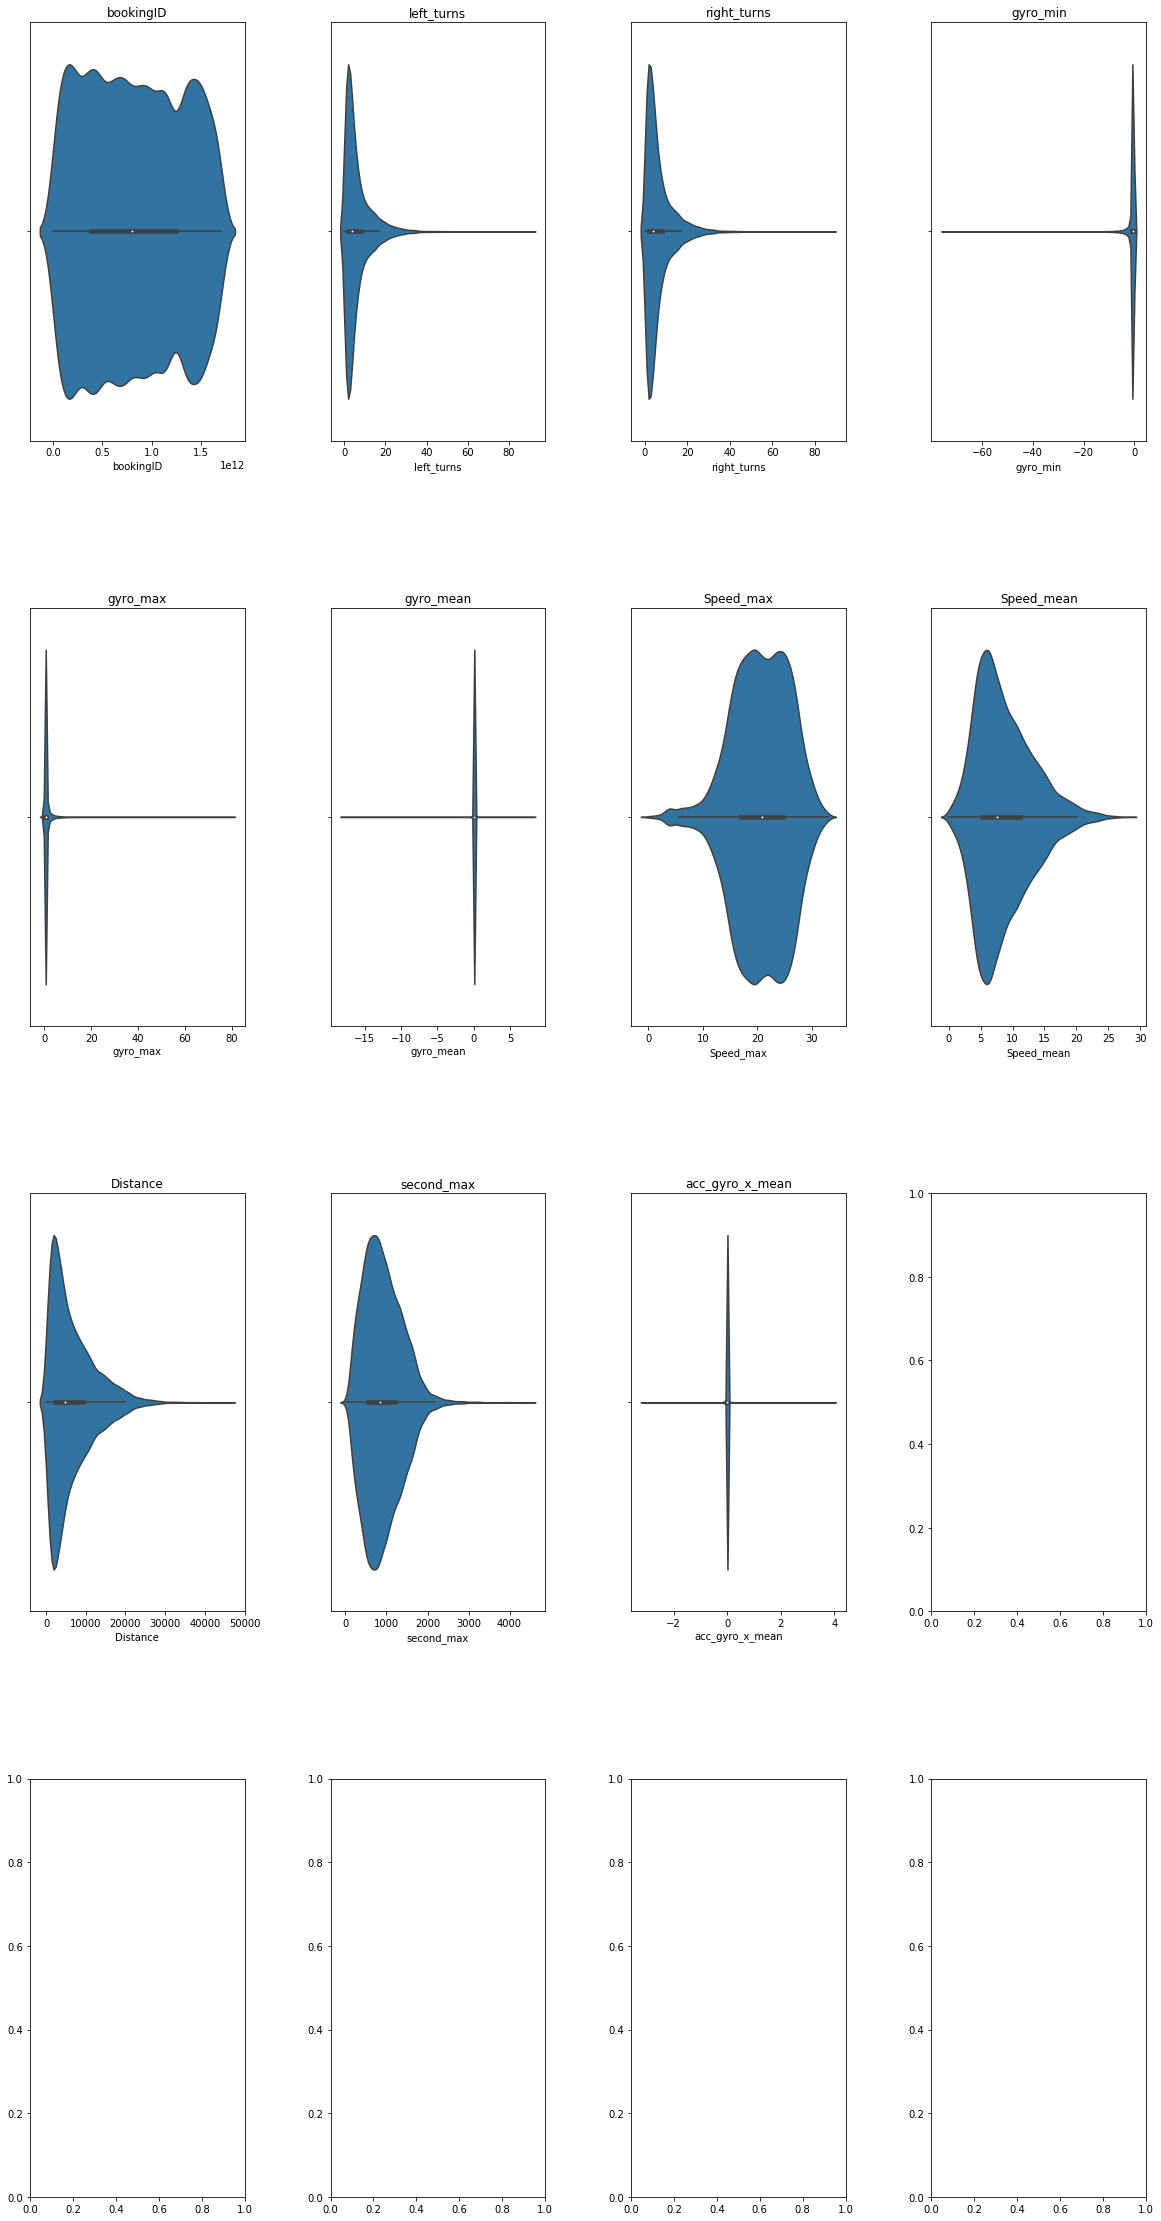

In [27]:
%%time
fig, axes = plt.subplots(4, 4)
fig.set_figheight(40)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(data.columns)):
    row = i // 4
    column = i % 4
    sns.violinplot(features_data[features_data.columns[i]], ax=axes[row, column]).set_title("{}".format(features_data.columns[i]))


In [28]:
from sklearn.model_selection import train_test_split, cross_val_score

y = features_data['label']
X = features_data.drop(['bookingID', 'label'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.20, random_state = 2)


# Gradient Boosting Algorithm

In [29]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

clf = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
clf.fit(x_train, y_train)
clf.score(x_train,y_train)

0.798873845375174

In [30]:
clf.score(x_test,y_test)

0.7856781376518218

In [31]:
from sklearn.metrics import roc_auc_score, classification_report
prediction = clf.predict(x_test)

prediction = prediction.astype(np.int)
y_test = y_test.astype(np.int)

print(roc_auc_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.5816156268975886
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      3001
           1       0.70      0.19      0.30       951

    accuracy                           0.79      3952
   macro avg       0.75      0.58      0.59      3952
weighted avg       0.77      0.79      0.73      3952



In [32]:
importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(25)

,importance
feature,
second_max,0.365
Speed_mean,0.072
Speed_max,0.059
acc_gyro_xz_mean,0.056
Distance,0.052
left_turns,0.042
right_turns,0.039
net_acceleration_max,0.032
net_acceleration_min,0.031


In [33]:
from sklearn.metrics import roc_curve, auc
# Compute micro-average ROC curve and ROC area
y_pred = clf.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5816156268975886


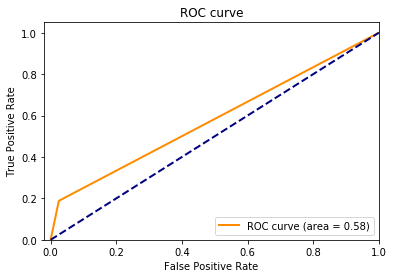

In [34]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting Regressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

#X, y = make_regression(random_state=0)

reg = GradientBoostingRegressor(random_state=0)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

#reg.score(x_test, y_test)
roc_auc_score(y_test, y_pred)


0.7188078912356939

0.7188078912356939


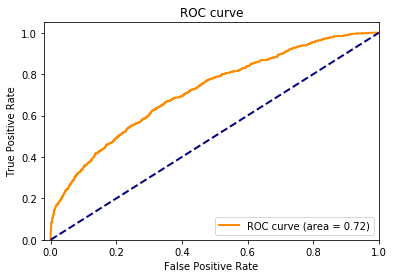

In [36]:
y_pred = reg.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# XG Boost (pip install this module)

In [37]:
import xgboost as xgb

xg_class = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_class.fit(x_train,y_train)
xg_class.score(x_test,y_test)

0.7798582995951417

0.5468965654981462


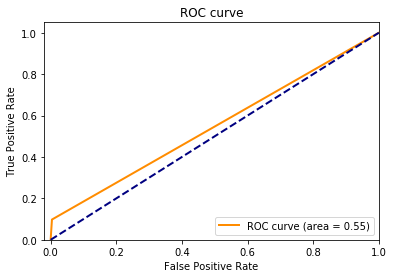

In [38]:
y_pred = xg_class.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

lr.score(x_test,y_test)


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7793522267206477

0.5788869535601697


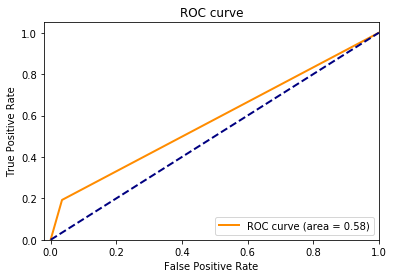

In [40]:
y_pred = lr.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest 

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, max_depth=9)

rf.fit(x_train, y_train)

rf.score(x_test,y_test)

0.7851720647773279

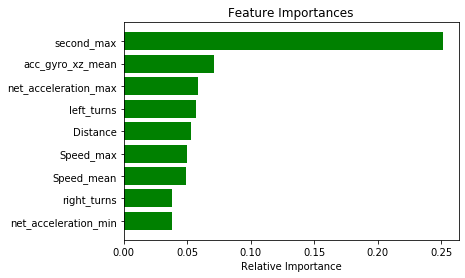

In [42]:
features = x_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [43]:
%%time
roc_score = []

clf_predict = cross_val_score(clf, x_test, y_test, cv=5, scoring='accuracy')
roc_score.append(np.mean(clf_predict))

xg_predict = cross_val_score(xg_class, X, y, cv=5, scoring='accuracy')
roc_score.append(np.mean(xg_predict))

lr_predict = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
roc_score.append(np.mean(lr_predict))

rf_predict = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
roc_score.append(np.mean(rf_predict))

print(roc_score)

#print("Gradient Boosting ROC_AUC cv fold: ", cv_predict)
#print("gradient boosting Mean 5-fold roc_auc: {}".format(np.mean(cv_predict)))

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

[0.7828955496167327, 0.7732566679680335, 0.7733578313080172, 0.7798869911476313]
Wall time: 25.3 s


# attempting to stack the model

In [61]:
%%time
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('gbc', GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)))
level0.append(('rf', RandomForestClassifier(n_estimators=30, max_depth=9)))
# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

model.fit(x_train, y_train)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

Wall time: 1min 47s


StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
                               ('gbc',
                                GradientBoostingClassifier(ccp_alpha=0.0,
                              

In [62]:
model.score(x_test,y_test)

0.7869433198380567

0.5825264694453408


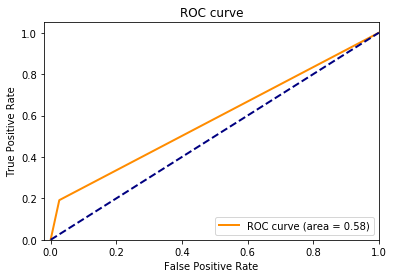

In [60]:
y_pred = model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [55]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

KeyboardInterrupt: 

In [47]:
#import pickle
#pickle.dump(clf, open('grab_model.pkl','wb'))

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(x_train, y_train)

print("score on test: " + str(adb.score(x_test, y_test)))
print("score on train: "+ str(adb.score(x_train, y_train)))

score on test: 0.7806174089068826
score on train: 0.7900797165633304


In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

mnb = GaussianNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = svm.SVC()

evc = VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='hard')
evc.fit(x_train, y_train)
print("score on test: " + str(evc.score(x_test, y_test)))
print("score on train: "+ str(evc.score(x_train, y_train)))

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


score on test: 0.7773279352226721
score on train: 0.7754650132860939
